# T-Maze

Experiments with modifications to the t-maze enviroment.

see https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class TMaze:   
    
    def __init__(self, size=3):
        self.size = size #takes size number of steps to reach decision node
    
    def __str__(self):
        statement = "Position: {}, Size: {}, Goal: {} ".format(self.position, self.size, self.getGoal(self.goal)) 
        return statement
                
    def getGoal(self, num):
        if num == 1:
            return "E"
        else:
            return "W"
        
    def step(self, action):
        """
        action - [0,1,2,3]
        directions = ["N","S","E","W"]
        Returns observation and reward
        """
        dx,dy = self.getDis(action)
        
        reward = 0
        done = False
        
        self.position += dy
        
        #going beyond maze upwards
        if self.position > self.size:
            reward = -0.1
            self.position += -1
        #downwards
        elif self.position < 0:
            reward = -0.1
            self.position += 1
            
        #moving left or right    
        if dx != 0:
            if self.position == self.size:
                if dx == self.goal:
                    reward = 4
                else:
                    reward = -0.1
                self.reset()
                done = True
            else:
                reward = -0.1
        
        return self.getObs(self.position),reward, done    
            
        
    def getObs(self, position):
        if position == 0:
            return self.observations[0]
        elif position == self.size:
            return self.observations[2]
        else:
            return self.observations[1]
    
    def getDis(self, action):
        """
        returns dx and dy, that represent change in position 
        """
        dis = [(0,1), (0,-1), (1,0), (-1,0)]
        return dis[action]
    
    def getAction(self, action):
        """
        for abstraction
        """
        directions = ["N","S","E","W"]
        return directions[action]
    
    def reset(self):
        
        """ Resets and returns initial observation """
        self.position = 0
        goal = random.choice([1,-1])
        self.goal = goal # 1 = 'E' -1 = 'W'        
        #'110' is W ;011 is E, corridor, decision node
        if goal == 1:
            self.observations = [(0,1,1),(1,0,1), (0,1,0)]
        else:
            self.observations = [(1,1,0),(1,0,1), (0,1,0)]
        return self.getObs(0)
    

In [3]:
env = TMaze() #size 3
print(env.reset())

print(env)

print(env.step(1))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))

(1, 1, 0)
Position: 0, Size: 3, Goal: W 
((1, 1, 0), -0.1, False)
((1, 1, 0), -0.1, False)
((1, 0, 1), 0, False)
((1, 0, 1), 0, False)
((0, 1, 0), 0, False)
((0, 1, 0), -0.1, False)
((0, 1, 1), -0.1, True)


In [4]:
print(env)

Position: 0, Size: 3, Goal: E 


In [5]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def act(self, obs,reward, done):
        return random.choice([0,1,2,3])

In [6]:
randAgent = RandomAgent()
env = TMaze()
obs = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 100
totalSteps = []
for i in range(episodes):
    cumReward = 0
    for step in range(1000):
        action = randAgent.act(obs,reward, done)
        obs,reward,done = env.step(action)
        cumReward += reward
        if done:
            break
    totalSteps.append(step)
    totalRewards.append(cumReward)
    #print("CumReward: {}, Steps: {}, Episode: {} ".format(cumReward, step, i)) 


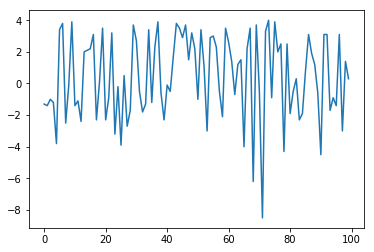

In [7]:
plt.plot(range(episodes), totalRewards)
plt.show()

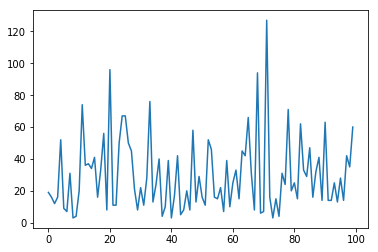

In [8]:
plt.plot(range(episodes), totalSteps)
plt.show()

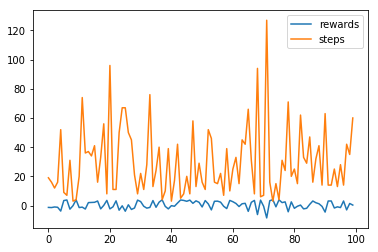

In [9]:
plt.plot(range(episodes), totalRewards, label = "rewards")
plt.plot(range(episodes), totalSteps, label = 'steps')
plt.legend()
plt.show()

# LSTM Agent as per 

https://arxiv.org/pdf/1507.06527.pdf
    

In [109]:
# Our Fast / Slow model
class LSTM_Agent(nn.Module):
    
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)
        
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x):
                
        h = F.relu(self.hidden(x))        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        h = h.unsqueeze(0)
        memory_activations, (self.h_state, self.c_state) = self.lstm(h, (self.h_state, self.c_state))
        q_out = self.q(memory_activations)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
        

In [110]:
# Hyper Parameters

GAMMA = 0.98
EPSILON = 0.10
LEARNING_RATE = 0.0003

PRINT_EVERY = 1000

In [173]:
def eval_agent(agent, env, trials=100):
    """ Evaulates agent by running it greed through a number of trials.
        Returns average reward.
    """
        
    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []

    for i in range(trials):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation, e_greedy=False)    

        max_steps = 100

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation, e_greedy=False)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            
            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        totalSteps.append(step)
        totalRewards.append(cumReward)
        
    return np.mean(totalRewards)

def run_test(depth, verbose=False):

    global totalRewards
    global totalSteps
    global scoreHistory
    
    agent = LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    env = TMaze(depth)

    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []
    scoreHistory = []
    episodes = 10000000
    
    for i in range(episodes):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation)    

        max_steps = 1000

        if i % 10000 == 0 and i != 0:
            print(".",end='')
            sys.stdout.flush() # makes the prints happen immediately
            
        if i % PRINT_EVERY == 0 and i != 0:
            
            av_reward = np.mean(totalRewards[-1000:])
            score = eval_agent(agent, env)
            
            if verbose:
                print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f} score:{:.3f}".format(
                    i, 
                    av_reward,
                    np.mean(totalSteps[-1000:]),
                    EPSILON,
                    score))
                
            scoreHistory.append((i, score))
            
            if score >= 4.0 * 0.95:
                # we give the agent a little grace,
                # also, eval turns off e-greedy.
                # as far as I can tell the agent should converge to 4.0
                return i

        loss = 0

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            loss += (reward + GAMMA * v - q)**2     

            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        # apply update
        loss.backward()
        agent.optimizer.step()

        #EPSILON = EPSILON * (1-1/1000)

        totalSteps.append(step)
        totalRewards.append(cumReward)
    
    print("Did not converge.")
    
    print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON
    ))
    return -1
    

.
0: 11K


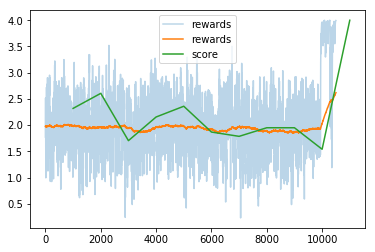

..
5: 20K


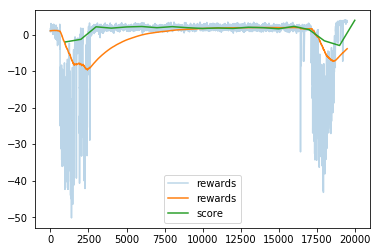

..
10: 24K


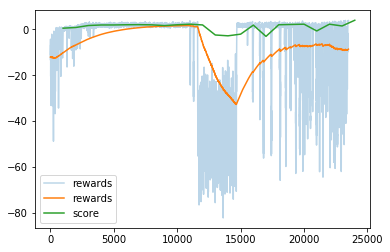

.
15: 15K


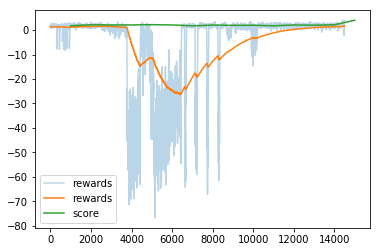

...............
20: 153K


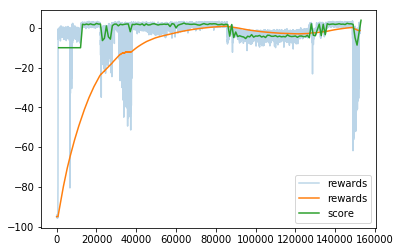

......
25: 65K


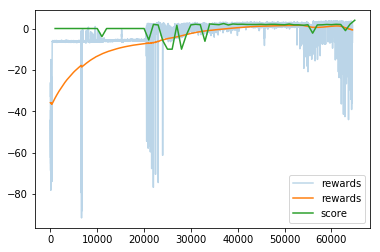

.........
30: 93K


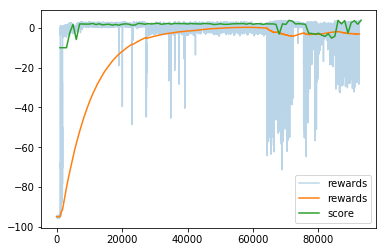

......
35: 67K


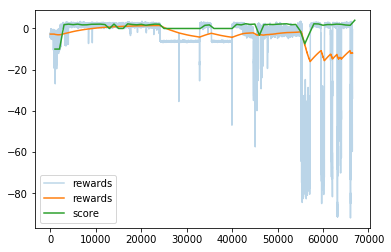

...
40: 36K


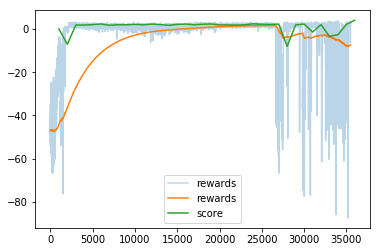

.........
45: 97K


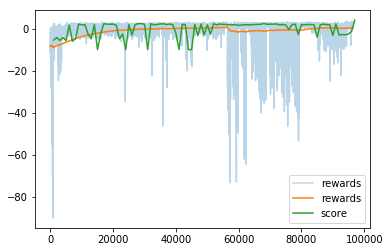

.........
50: 94K


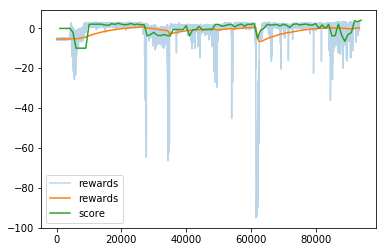

......
55: 68K


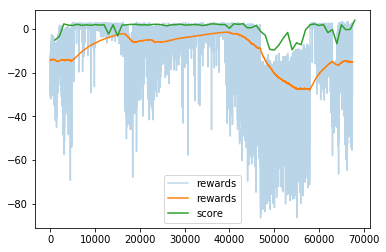

..........

KeyboardInterrupt: 

In [130]:
# results:
# 0.1/0001 = 39, 148, ...
# 0.1/0003 = 9,15,17,17,-1,-1
# 0.1/001 = 6, 55, 4, 4, 

# changed to 3.0 cut off
# 0.1/001 = 4, 5, 3, 7,

# change to proper evaluations
# 0.1/001 = 4, 1, 4, 4, 14, 8, 5, 11

# ALSO TRY circulum learning
# plus I think the IID replay buffer will be very important.

# results: 
# 0.1/001 0=1, 5=21, 10=15, 15= 200k+
# 0.2/001 0=6, 5=6,  10=30+
# 0.05/001 0=3 5=26

#fixed egreedy error
# 0.05/001 0=6 5=120+

# 0.10/0003 0=27, 5=
# 0.10/0003 0


results = []

for depth in range(0,70,5):
    steps = run_test(depth)//1000
    print("\n{}: {}K".format(depth, steps))
    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
    plt.plot(range(len(totalRewards[5030:])), smooth(totalRewards[500:],1-(1/(0.1*len(totalRewards)))), label = "rewards")
    plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
    plt.legend()
    plt.show()

    results.append((depth, steps))

In [174]:
for depth in range(60,75,5):
    steps = run_test(depth)//1000
    print("\n{}: {}K".format(depth, steps))
    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
    plt.plot(range(len(totalRewards[5030:])), smooth(totalRewards[500:],1-(1/(0.1*len(totalRewards)))), label = "rewards")
    plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
    plt.legend()
    plt.show()

    results.append((depth, steps))

NameError: name 'LEARNING_RATE' is not defined

In [ ]:
print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON))


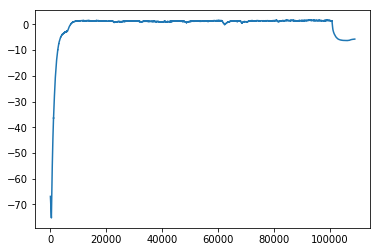

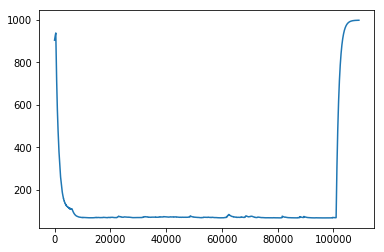

In [132]:
def smooth(X, gamma = 0.9):
    """ Returns exponential moving average. """
    y = np.mean(X[:500])
    out = []
    for x in X:
        y = gamma * y + (1-gamma) * x
        out.append(y)
    return out

plt.plot(range(len(totalRewards[100:])), smooth(totalRewards[100:],0.999), label = "rewards")
plt.show()
plt.plot(range(len(totalSteps)), smooth(totalSteps, 0.999), label = 'steps')
plt.show()

In [ ]:
print(totalSteps)